In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
import scipy.interpolate as inter
import plotly.express as px
from sklearn import preprocessing as skprep
import numba
import timeit
import math
import itertools
from pprint import pprint
from mnk import MNK

In [14]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

In [15]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    dfn = x.size-1 #define degrees of freedom numerator
    dfd = y.size-1 #define degrees of freedom denominator
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic
    return f, p

In [16]:
df = pd.read_csv("DataSet1_3.csv", sep=',')
df = df.dropna()

df["Date"] = pd.to_datetime(df["Date"])
df["Date"] = norm(df["Date"].values.astype("float64"))

df = df.drop(columns=[
    'Name', "Date"
])
df = df.drop_duplicates()
df = df.reset_index(drop=True)

predict_column = "Close"

columns = list(df.columns)
columns.remove(predict_column)
columns = [predict_column] + columns
columns = pd.Index(columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.1 KB


In [17]:
df

,Open,High,Low,Close,Volume
0,211.47,218.05,209.32,217.83,13137450
1,222.17,224.70,220.09,222.84,15292353
2,223.22,226.00,220.97,225.85,10815661
3,228.66,235.49,226.85,233.06,17759521
4,233.44,236.94,230.70,233.68,12795837
...,...,...,...,...,...
3014,1070.00,1071.72,1067.64,1068.86,889446
3015,1068.64,1068.86,1058.64,1065.85,918767
3016,1066.60,1068.27,1058.38,1060.20,1116203
3017,1062.25,1064.84,1053.38,1055.95,994249


In [18]:
df.nunique()

Open      2880
High      2855
Low       2875
Close     2919
Volume    3019
dtype: int64

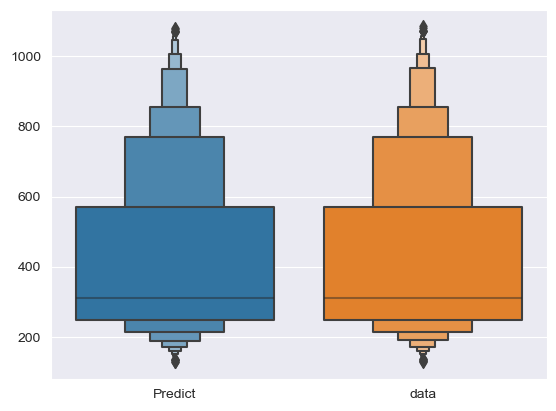

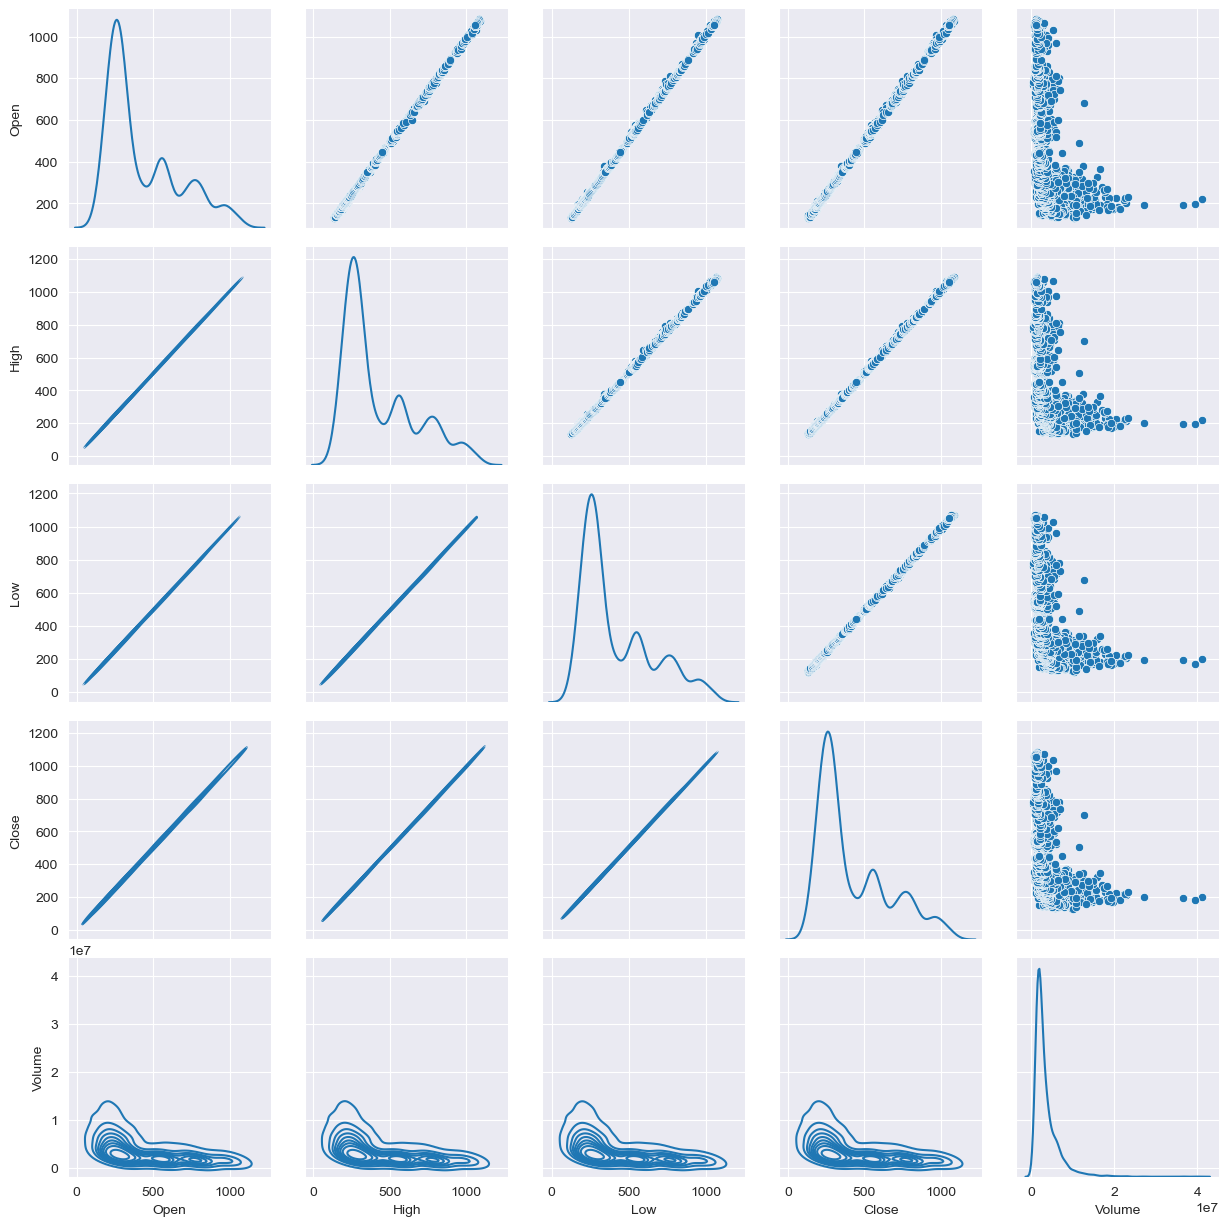

In [19]:
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
plt.show()

# Sample

In [20]:
sample = df.sample(
    # 5
    int(len(df) * 0.3)
)
sample = sample.drop_duplicates(subset=[predict_column])
indexes = df.index.delete(df.index.isin(sample.index))
sample = sample.sort_values(by=predict_column)
sample = sample.reset_index(drop=True)
X = sample.loc[0:len(sample), columns[~columns.isin([predict_column])]].to_numpy()
y = sample.loc[0:len(sample), [predict_column]].to_numpy()

In [21]:
sample

,Open,High,Low,Close,Volume
0,134.76,135.11,124.63,128.85,10059557
1,131.39,134.82,123.77,131.35,10246338
2,138.40,141.89,134.52,137.31,4887799
3,135.00,139.03,131.42,137.69,5841927
4,134.47,143.47,133.79,141.17,10774259
...,...,...,...,...,...
886,1050.05,1062.69,1047.05,1058.29,1214600
887,1073.99,1080.00,1054.54,1063.29,1821171
888,1070.00,1071.72,1067.64,1068.86,889446
889,1075.39,1077.52,1069.00,1070.85,1282025


# МНК

In [22]:
funcs = [
    lambda x: x[0] ** 0,
    lambda x: x[0],
    lambda x: x[0] ** 2,
    lambda x: x[1],
    lambda x: x[1] ** 2,
    lambda x: x[2],
    lambda x: x[2] ** 2,
    lambda x: x[3],
    lambda x: x[3] ** 2,
    # lambda x: x[4],
    # lambda x: x[4] ** 2,
    # lambda x: x[5],
    # lambda x: x[5] ** 2,
    # lambda x: x[6],
    # lambda x: x[6] ** 2,
]
# funcs[1](df.loc[:, 1:6].to_numpy().T), funcs[16](df.loc[:, 1:6].to_numpy().T)
mnk = MNK(sample.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T, sample[predict_column].values, funcs)
# mnk = MNK(df.loc[:, 1:6].to_numpy().T, df[7].values, funcs)
mnk.c

array([-7.64824348e-01, -5.43504063e-01, -8.17362085e-07,  9.78827971e-01,
       -1.44966652e-04,  5.65095505e-01,  1.47597708e-04, -5.33139154e-08,
        3.26625866e-15])

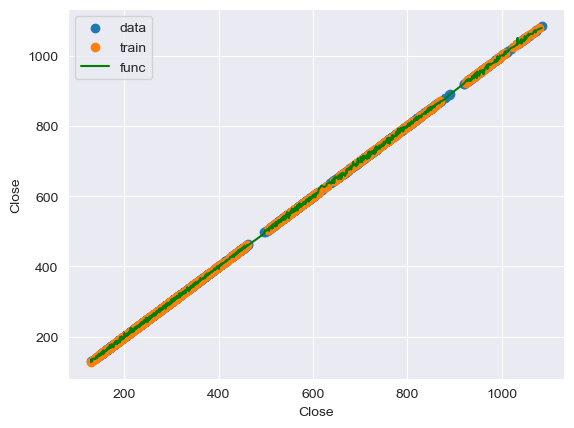

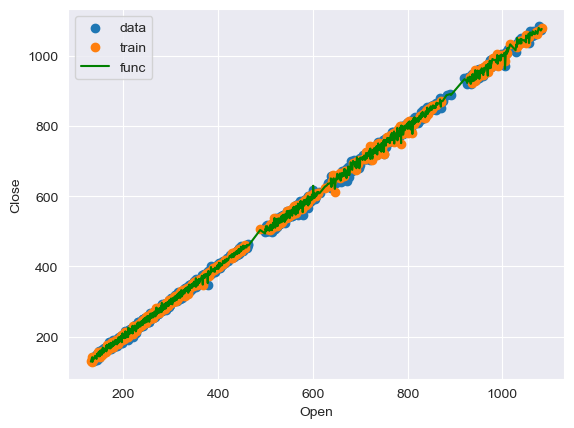

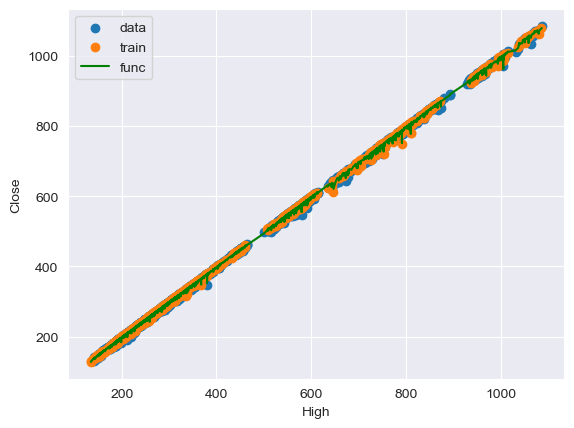

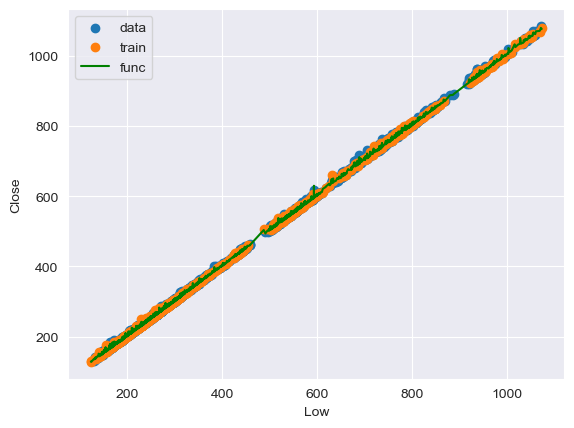

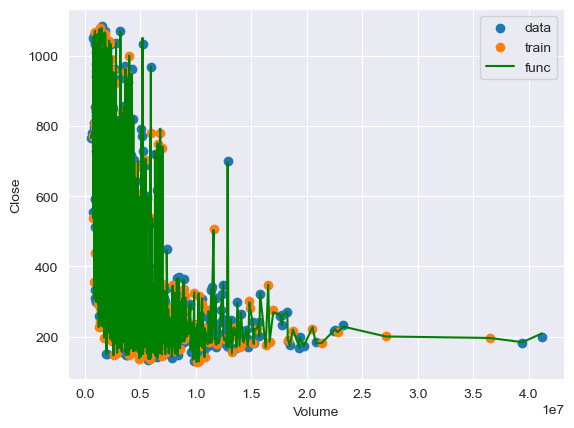

In [23]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], mnk(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T), label='func', color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T)
exp_data = exp_data.reshape(len(exp_data))

In [24]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [25]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=0.0001092938707215491, pvalue=0.9999127997198842)
F-test   stat = 0.999291517595002, pvalue = 0.5077653179177675
X2       stat = 20.459518115756158, pvalue = 1.0


# kNN

In [26]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

KNeighborsRegressor()

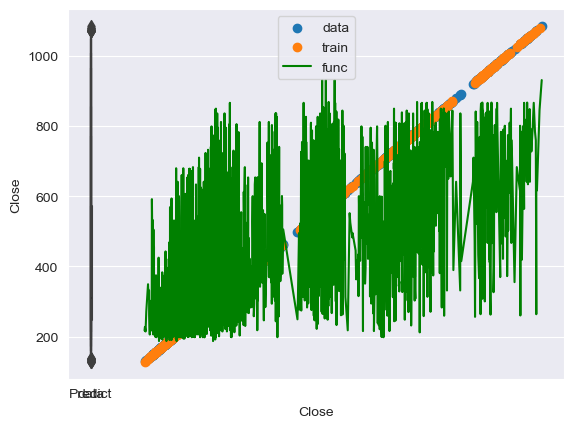

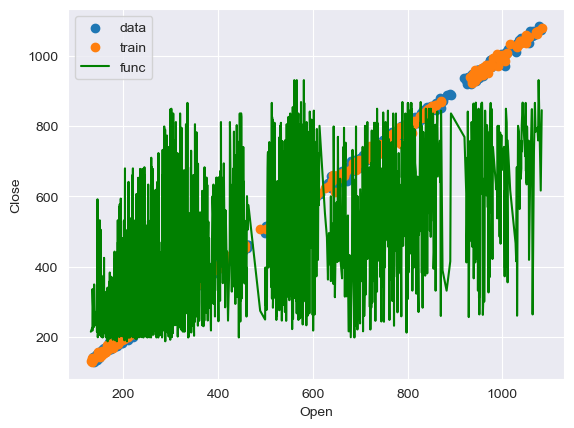

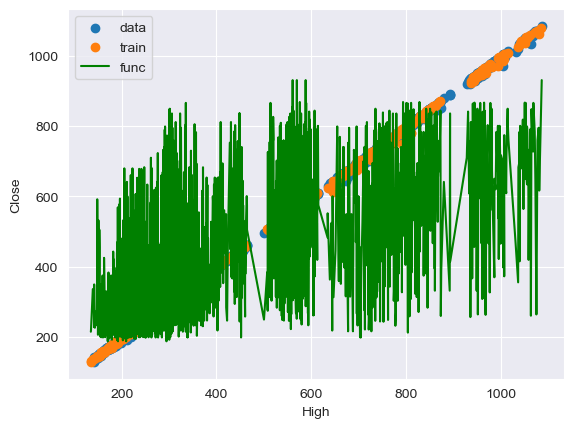

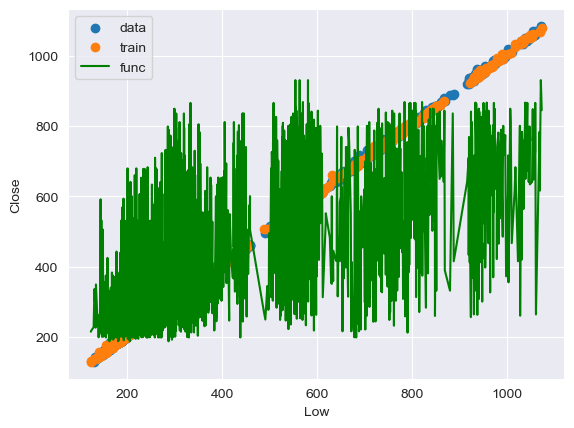

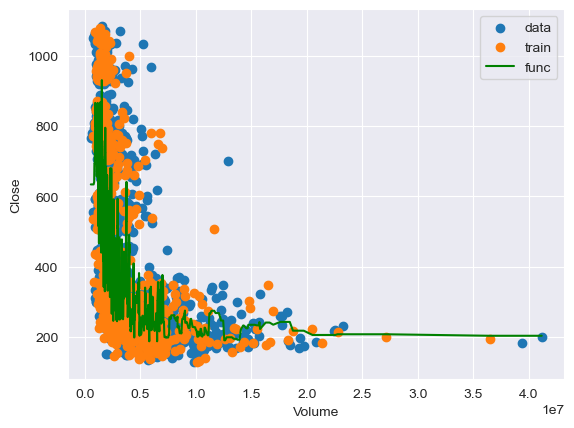

In [27]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], neigh.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = neigh.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

In [28]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [29]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=1.811429715344134, pvalue=0.07012404325645642)
F-test   stat = 0.583689006441746, pvalue = 1.0
X2       stat = 108172.83254156414, pvalue = 0.0


# Lasso

In [30]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.5)
lasso.fit(X, y)

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+04, tolerance: 5.420e+03
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.5)

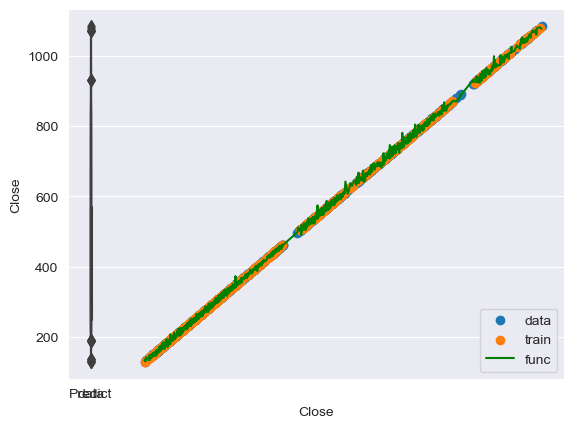

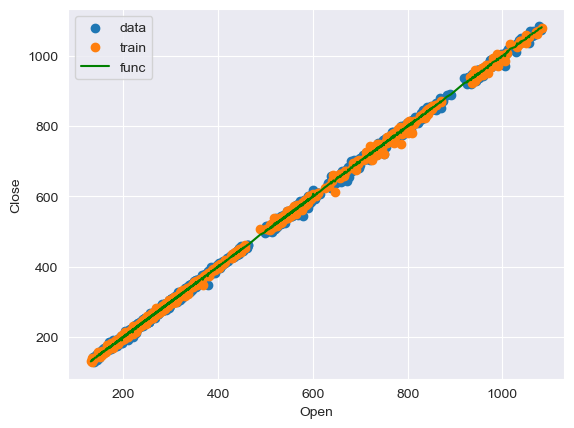

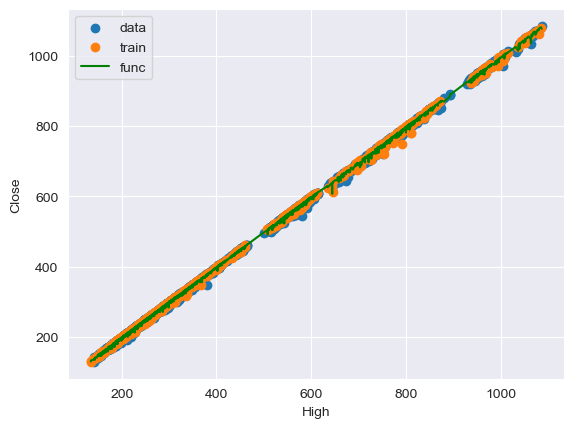

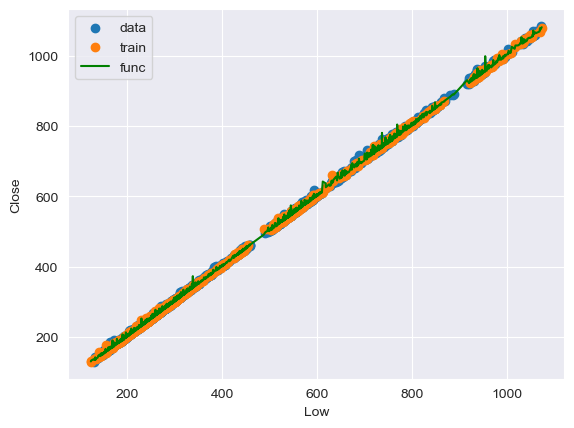

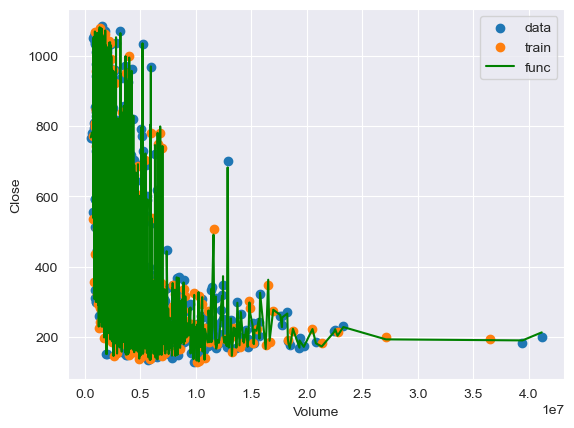

In [31]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], lasso.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = lasso.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())

In [32]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [33]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.008871469645292883, pvalue=0.9929219773660378)
F-test   stat = 0.9997815914569051, pvalue = 0.5023934158346992
X2       stat = 72.37485855195439, pvalue = 1.0


# Ridge

In [34]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5)
ridge.fit(X, y)

Ridge(alpha=0.5)

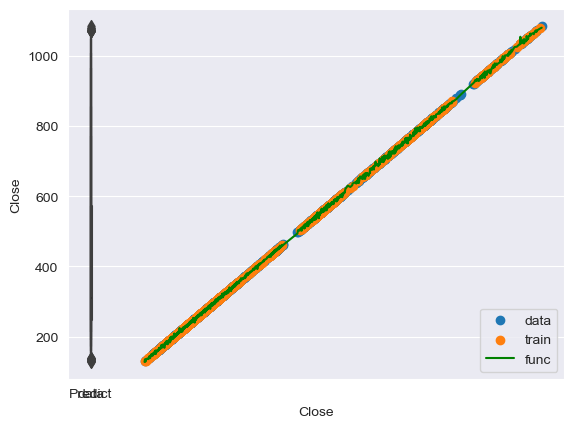

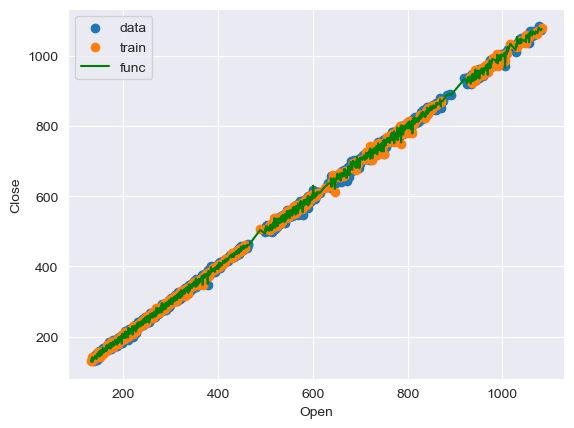

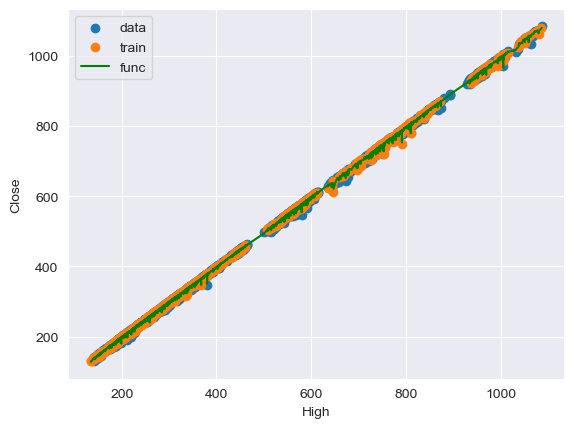

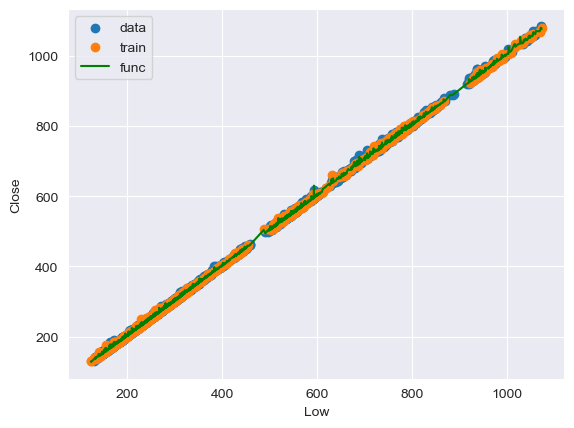

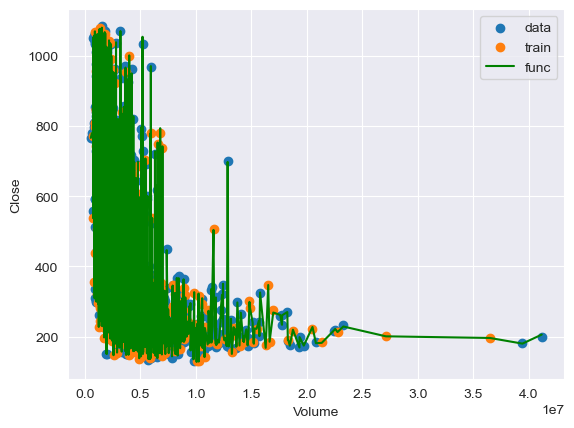

In [35]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], ridge.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = ridge.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

In [36]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [37]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=0.0017958227347497147, pvalue=0.9985672008814171)
F-test   stat = 0.9992379411606971, pvalue = 0.5083526832119398
X2       stat = 20.020134225037214, pvalue = 1.0
